In [1]:
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_df = pd.read_json("polyrating.json",orient='columns')

def flatten(a):
    try:
        return a[0]
    except:
        return a
    
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [2]:
raw_df1 = explode(raw_df,"reviews")
split_review = raw_df1["reviews"].apply(pd.Series)
df = raw_df1.join(split_review)

In [3]:
df = df.drop("reviews",axis=1)

## Cleaning

### Make rating numeric

In [4]:
df["agg_rating"] = pd.to_numeric(df["agg_rating"].str[:4], errors="coerce")

In [5]:
def get_course_num(course):
    if len(course) == 2:
        return course[1]
    else:
        return course

df["year"] = df["date"].str.extract('(\d+)')
df["month"] = df["date"].str[:3]
df["course_num"] = pd.to_numeric(df["class"].str.split("_").apply(get_course_num))
df["level"] = pd.to_numeric(df['course_num'].astype(str).str[0] + "00")

df = df[(df["course_num"] > 99) & (df["course_num"] < 551)]

df["name_class"] = df["prof_name"] + ' (' + df["subject"] + ")"
df.drop("subject",axis=1, inplace =True)
df.drop("prof_name",axis=1, inplace=True)

## Average Grade by Year

In [6]:
df["gpa"] = df.grade.map({
    "A":4,
    "B":3,
    "C":2,
    "D":1,
    "F":0
})

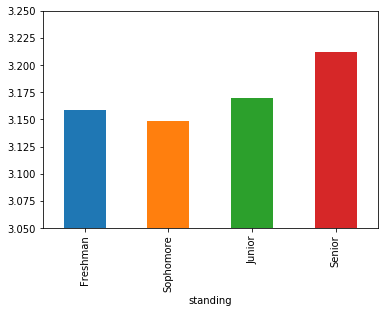

In [7]:
df.groupby("standing")["gpa"].mean()[["Freshman", "Sophomore", "Junior", "Senior"]].plot.bar(ylim=(3.05, 3.25))

## Average Rating of Professor by Year

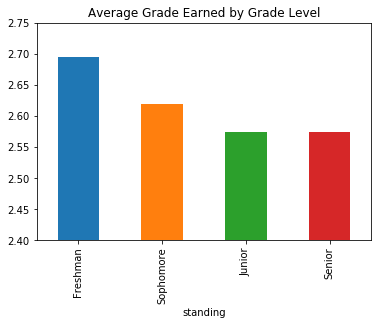

In [8]:
df.groupby("standing")["agg_rating"].mean()[["Freshman", "Sophomore", "Junior", "Senior"]].plot.bar(ylim=(2.4, 2.75), title="Average Grade Earned by Grade Level")

## Polyrating vs. Average Grade

In [10]:
profs = df["name_class"].value_counts()[df["name_class"].value_counts() > 30].to_frame().index.tolist()
high_rating_count = df[(df["name_class"].isin(profs))]

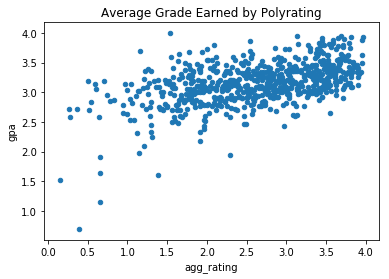

In [12]:
professor_means = high_rating_count.groupby("name_class")[["agg_rating","gpa"]].mean()
high_rating_count.groupby("name_class")[["agg_rating","gpa"]].mean().plot.scatter(x="agg_rating", y="gpa", title="Average Grade Earned by Polyrating")

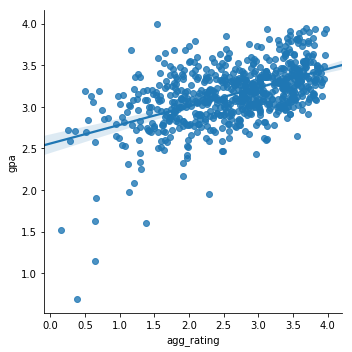

In [13]:
import seaborn as sns
import math

avg_rev_len = high_rating_count.groupby("name_class")["review"].apply(lambda x: np.mean(x.str.len()))
professor_means["avg_rev_len"] = avg_rev_len
sns.lmplot(x="agg_rating", y="gpa", data=professor_means, fit_reg=True)
professor_means["log_transform"] = np.log(professor_means["avg_rev_len"])

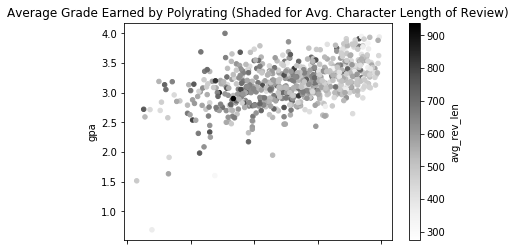

In [14]:
professor_means[professor_means["avg_rev_len"] < 1000].plot.scatter(x="agg_rating", y="gpa", c="avg_rev_len", title="Average Grade Earned by Polyrating (Shaded for Avg. Character Length of Review)")

## Avg. Grade by Course Type

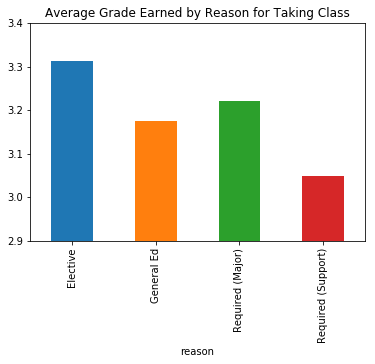

In [15]:
df.groupby("reason")["gpa"].mean().drop("N/A").plot.bar(ylim=(2.9, 3.4), title="Average Grade Earned by Reason for Taking Class")

## Avg. Grade by Year and Month

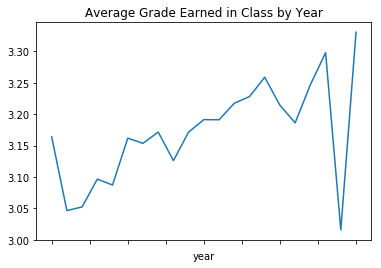

In [16]:
df.groupby("year")["gpa"].mean().plot(title="Average Grade Earned in Class by Year")

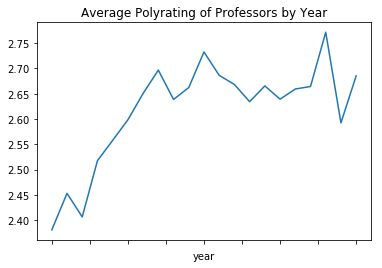

In [17]:
df.groupby("year")["agg_rating"].mean().plot(title="Average Polyrating of Professors by Year")

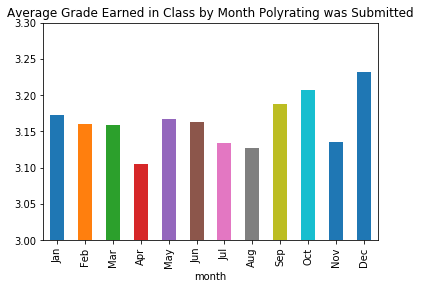

In [18]:
df.groupby("month")["gpa"].mean()[["Jan", "Feb", "Mar", "Apr","May", "Jun",
                                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]].plot.bar(ylim=(3, 3.3), title="Average Grade Earned in Class by Month Polyrating was Submitted")

## Average Grade by Course Level

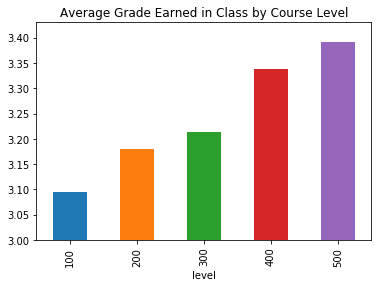

In [19]:
df.groupby("level")["gpa"].mean().plot.bar(ylim=(3, 3.43), title="Average Grade Earned in Class by Course Level")

## Polyrating by Keywords

In [20]:
df["awesome"] = df["review"].str.contains("awesome")
df["shit"] = df["review"].str.contains("shit")

awesome
False    2.602295
True     3.090410
Name: agg_rating, dtype: float64

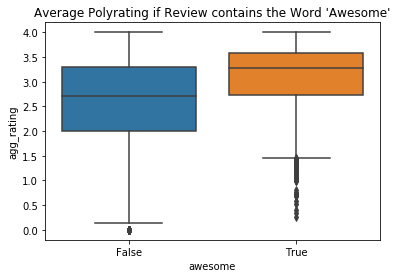

In [72]:
import seaborn as sns

sns.boxplot(x="awesome", y="agg_rating", data=df).set_title("Average Polyrating if Review contains the Word 'Awesome'")
df.groupby("awesome")["agg_rating"].mean()

shit
False    2.635707
True     2.358353
Name: agg_rating, dtype: float64

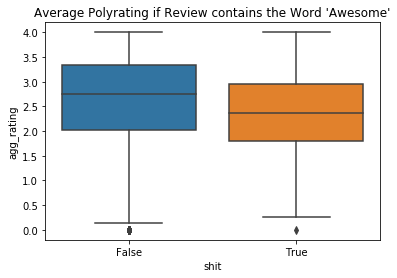

In [73]:
sns.boxplot(x="shit", y="agg_rating", data=df).set_title("Average Polyrating if Review contains the Word 'Awesome'")
df.groupby("shit")["agg_rating"].mean()

In [74]:
top_adj = ["helpful", "clear", "kind", "funny", "terrible", "confused", "happy", "enthusiastic", "excited",
          "sweet", "friendly", "wonderful", "perfect", "lazy", "frusterating", "fantastic", "arrogant",
           "condescending", "bored", "energetic", "dull", "odd", "strange", "sarcastic", "pleasant", "witty",
           "pompous", "creepy"]

In [28]:
listofadj = []
df_test = pd.DataFrame(columns=["name_class","adjectives"])
for prof in df["name_class"].unique():
    prof_sub = df[df["name_class"] == prof]
    adj_dict = {}
    for adj in top_adj:
        adj_dict[adj] = 0
    for review in prof_sub["review"]:
        for word in review.lower().split():
            if word in top_adj:
                adj_dict[word] += 1
    df_test = df_test.append({"name_class": prof,
                              "adjectives": adj_dict}, ignore_index=True)

In [111]:
df_test_adj = df_test["adjectives"].apply(pd.Series)
temp = df_test.join(df_test_adj).drop("adjectives",axis=1)
temp

full = pd.merge(df,temp,
       on = "name_class",
       how = "left").drop(["standing", "course_num", "level", "class", "reason", "date", "review", 
                           "year", "month", "gpa", "awesome", "shit", "grade"], axis=1
                         ).drop_duplicates()

full.loc[55106, "agg_rating"] = 1.86
full.drop(55156, inplace=True)
full.loc[63045, "agg_rating"] = 3.75
full.drop(63069, inplace=True)
full.loc[38836, "agg_rating"] = 2.53
full.drop(38843, inplace=True)
full.loc[62886, "agg_rating"] = 2.95
full.drop(62905, inplace=True)
full.loc[3547, "agg_rating"] = 2.41
full.drop(3591, inplace=True)
full.loc[35023, "agg_rating"] = 1.62
full.drop(35039, inplace=True)

In [112]:
full2 = full.set_index("name_class")

In [113]:
full2["total_adj"] = full2.sum(axis=1) - full2['agg_rating']

In [114]:
same = [('Aberbromby, Kira (AERO)', 'abercromby, kira (AERO)')]

for item1, item2 in same:
    full2.loc['Aberbromby, Kira (AERO)'] = full2.loc['Aberbromby, Kira (AERO)'] + full2.loc['abercromby, kira (AERO)']
    full2.loc['Aberbromby, Kira (AERO)', "agg_rating"] = full2.loc['Aberbromby, Kira (AERO)', "agg_rating"] / 2
    full2.drop('abercromby, kira (AERO)', inplace=True)

In [115]:
for adj in top_adj:
    full2[adj] = full2[adj] / full2["total_adj"]
full2.fillna(0, inplace=True)

In [116]:
full2.drop("total_adj", axis=1, inplace=True)

In [117]:
from sklearn.metrics import pairwise_distances

D_ = pairwise_distances(full2, metric="euclidean")
np.fill_diagonal(D_, np.inf)
D_ = pd.DataFrame(D_)

In [118]:
D_.head()

,0,1,2,3,4,5,6,7,8,9,...,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467
0,inf,0.304769,1.089088,1.904466,1.012525,1.230493,1.008261,0.759250,0.845841,0.656828,...,0.733770,0.448129,0.599171,2.088607,1.154508,1.102563,0.644784,1.318886,0.527428,1.887356
1,0.304769,inf,1.023771,1.986435,1.109890,1.340976,1.084954,0.804751,1.056253,0.800958,...,0.840410,0.532680,0.756088,2.226879,1.000857,0.939664,0.852743,1.419541,0.733991,1.974666
2,1.089088,1.023771,inf,2.400750,1.694944,1.845102,1.624315,1.321779,1.720581,1.403175,...,1.483779,1.271591,1.442556,2.721195,1.285340,1.276110,1.540162,1.915171,1.442429,2.433187
3,1.904466,1.986435,2.400750,inf,1.194939,1.346700,1.198165,1.773105,1.709269,1.584961,...,1.389244,1.690723,1.508300,1.319129,2.632280,2.537648,1.941365,1.110331,1.607794,1.414779
4,1.012525,1.109890,1.694944,1.194939,inf,0.534985,0.363366,0.949125,0.992555,0.739045,...,0.425451,0.736135,0.575991,1.230735,1.862143,1.751903,1.172035,0.425132,0.656877,1.063603


In [119]:
D_.set_index(full2.index, inplace=True)
D_2 = D_.T.set_index(full2.index)
D_2.set_index(full2.index)
D_2

name_class,"Abel, Christina (CHEM)","Aberbromby, Kira (AERO)","Abitia, Fred (IT)","Abler, Fred (ARCH)","Abney, Keith (PHIL)","Abney, Ray (ENGL)","Abshire, Franklin (MATH)","Acosta, Kellie (BIO)","Adam, Sandra (AGB)","Adams, Nikki (BIO)",...,"Zhang, Ning (POLS)","Zhang, Shanju (CHEM)","Zhang, Xiaozheng (EE)","Zinn, Jesse (ECON)","Zohns, Mark (BRAE)","Zohns, Michael (EHS)","Zoller, David (PHIL)","Zulfacar, Maliha (SOC)","Zumwalt, Marta (CHEM)","Zweifel, Dick (ARCH)"
name_class,,,,,,,,,,,,,,,,,,,,,
"Abel, Christina (CHEM)",inf,0.304769,1.089088,1.904466,1.012525,1.230493,1.008261,0.759250,0.845841,0.656828,...,0.733770,0.448129,0.599171,2.088607,1.154508,1.102563,0.644784,1.318886,0.527428,1.887356
"Aberbromby, Kira (AERO)",0.304769,inf,1.023771,1.986435,1.109890,1.340976,1.084954,0.804751,1.056253,0.800958,...,0.840410,0.532680,0.756088,2.226879,1.000857,0.939664,0.852743,1.419541,0.733991,1.974666
"Abitia, Fred (IT)",1.089088,1.023771,inf,2.400750,1.694944,1.845102,1.624315,1.321779,1.720581,1.403175,...,1.483779,1.271591,1.442556,2.721195,1.285340,1.276110,1.540162,1.915171,1.442429,2.433187
"Abler, Fred (ARCH)",1.904466,1.986435,2.400750,inf,1.194939,1.346700,1.198165,1.773105,1.709269,1.584961,...,1.389244,1.690723,1.508300,1.319129,2.632280,2.537648,1.941365,1.110331,1.607794,1.414779
"Abney, Keith (PHIL)",1.012525,1.109890,1.694944,1.194939,inf,0.534985,0.363366,0.949125,0.992555,0.739045,...,0.425451,0.736135,0.575991,1.230735,1.862143,1.751903,1.172035,0.425132,0.656877,1.063603
"Abney, Ray (ENGL)",1.230493,1.340976,1.845102,1.346700,0.534985,inf,0.714143,1.103585,1.288410,0.939415,...,0.731847,0.945522,0.782838,1.265899,2.032954,1.943722,1.446686,0.583274,0.816456,0.927362
"Abshire, Franklin (MATH)",1.008261,1.084954,1.624315,1.198165,0.363366,0.714143,inf,0.907689,1.044031,0.694622,...,0.421426,0.768989,0.603463,1.350000,1.813532,1.719900,1.203703,0.496019,0.754056,1.220656
"Acosta, Kellie (BIO)",0.759250,0.804751,1.321779,1.773105,0.949125,1.103585,0.907689,inf,1.229593,0.709507,...,0.793662,0.698363,0.771075,2.046314,1.369306,1.305739,1.172604,1.134198,0.823347,1.803303
"Adam, Sandra (AGB)",0.845841,1.056253,1.720581,1.709269,0.992555,1.288410,1.044031,1.229593,inf,0.950000,...,0.850647,0.896295,0.755977,1.613227,1.837634,1.765802,0.370000,1.205437,0.628172,1.732051


In [102]:
D_2.idxmin(axis=1)['Aberbromby, Kira (AERO)']

'Navarro, Jose (ENGL)'

In [103]:
full2["creepy"].sort_values(ascending=False)

name_class
Fahs, Michael (COMS)                0.222222
Gooden, Reginald (POLS)             0.200000
Doyle, D.Gregg (CRP)                0.166667
Strahl, Richard (IME)               0.166667
Rice, Thomas (SS)                   0.125000
Hall, Zachary (COMS)                0.125000
Hall, Michael (ASCI)                0.125000
Ausmus, William (COMS)              0.101695
Srinivasan, Prashant (PHYS)         0.100000
Raio, Larry (SS)                    0.100000
Harris, John (NRM)                  0.090909
Schnupp, Alvin (TH)                 0.090909
Devaney, Kevin (CE)                 0.090909
Lynch, Joe (PHIL)                   0.088235
Miller, Michael (ART)               0.076923
Wilhelm, Deborah (ENGL)             0.076923
Brown, Ronald (PHYS)                0.075000
Bethel, Walt (PHIL)                 0.066667
Mirahmad, Mortazavi Izadi (STAT)    0.058824
Olenowski, Jay (STAT)               0.058824
Jankovitz, Kristine (PE)            0.055556
Bishop, Roger (BUS)                 0.050000

In [104]:
full[full["name_class"] == 'Lindert, Lisa (CHEM)']

,agg_rating,name_class,helpful,clear,kind,funny,terrible,confused,happy,enthusiastic,...,bored,energetic,dull,odd,strange,sarcastic,pleasant,witty,pompous,creepy
35023,1.62,"Lindert, Lisa (CHEM)",4,0,0,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [105]:
full2.loc["McCleskey, Patrick (IT)"]

agg_rating       2.53
helpful          0.00
clear            0.00
kind             0.00
funny            0.00
terrible         0.00
confused         0.50
happy            0.50
enthusiastic     0.00
excited          0.00
sweet            0.00
friendly         0.00
wonderful        0.00
perfect          0.00
lazy             0.00
frusterating     0.00
fantastic        0.00
arrogant         0.00
condescending    0.00
bored            0.00
energetic        0.00
dull             0.00
odd              0.00
strange          0.00
sarcastic        0.00
pleasant         0.00
witty            0.00
pompous          0.00
creepy           0.00
Name: McCleskey, Patrick (IT), dtype: float64

In [106]:
full2.index.value_counts()

Thorncroft, Glen (ME)                1
Dettmar, Christopher (CHEM)          1
Slezak, Steven (MATH)                1
Cannellos, John (PHYS)               1
Seiver, Daniel (ECON)                1
Battersby, Jim (NRM)                 1
Griffin, Kimberly (CHEM)             1
raj, arul (ARCE)                     1
Duchowny, Laurie (SOC)               1
Alexander, Benjamin (BUS)            1
Reyes, Luis (PHYS)                   1
LaPorte, Mary (ART)                  1
Strand, Steve (MATH)                 1
McLaughlin, William (COMS)           1
Hill, Margarita (LA)                 1
Pouraghabagher, Sisi (BUS)           1
Wild, Rosemary (BUS)                 1
Finnegan, Kenneth (EE)               1
Barjami, Saimar (PHYS)               1
O'Hara, Christine (LA)               1
Archer, Graham (ARCE)                1
Morris, Andrew (HIST)                1
Garcia-Lemus, Mary (PSY)             1
Kathuria, Ajay (IT)                  1
Busselen Jr., Harry (PSY)            1
Mulligan, Patricia (EDUC)

In [120]:
full2

,agg_rating,helpful,clear,kind,funny,terrible,confused,happy,enthusiastic,excited,...,bored,energetic,dull,odd,strange,sarcastic,pleasant,witty,pompous,creepy
name_class,,,,,,,,,,,,,,,,,,,,,
"Abel, Christina (CHEM)",3.22,0.428571,0.095238,0.095238,0.000000,0.047619,0.047619,0.095238,0.047619,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
"Aberbromby, Kira (AERO)",3.34,0.272727,0.000000,0.090909,0.090909,0.090909,0.000000,0.090909,0.000000,0.000000,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
"Abitia, Fred (IT)",3.61,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
"Abler, Fred (ARCH)",1.67,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
"Abney, Keith (PHIL)",2.29,0.130435,0.130435,0.217391,0.086957,0.173913,0.000000,0.000000,0.000000,0.043478,...,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.043478,0.0,0.0,0.043478
"Abney, Ray (ENGL)",2.23,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
"Abshire, Franklin (MATH)",2.33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
"Acosta, Kellie (BIO)",3.00,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
"Adam, Sandra (AGB)",2.63,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
